# Package

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
import string
import re
import nltk
# from datetime import datetime
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Module, LSTM, Linear
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
import sys
import time
import logging
from logging.handlers import RotatingFileHandler

In [ ]:
nltk.download('all')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/4995 final proj/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/4995 final proj


In [ ]:
! unzip archive.zip

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


Dataset

# Dataset loading

In [ ]:
company = pd.read_csv('Company.csv')
company_tweet = pd.read_csv('Company_Tweet.csv')
company_values = pd.read_csv('CompanyValues.csv')
tweet  = pd.read_csv('Tweet.csv')
DJIA_prices = pd.read_csv('upload_DJIA_table.csv')
news = pd.read_csv('Combined_News_DJIA.csv')

In [ ]:
company.head()

,ticker_symbol,company_name
0,AAPL,apple
1,GOOG,Google Inc
2,GOOGL,Google Inc
3,AMZN,Amazon.com
4,TSLA,Tesla Inc


In [ ]:
merged_tweet = company_tweet.merge(tweet, how = 'inner', on = ['tweet_id'])
merged_tweet.post_date = pd.to_datetime(merged_tweet['post_date'], unit='s')

# news['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
# DJIA_prices['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

merged_tweet['Date']=merged_tweet['post_date'].apply(lambda x: x.date().strftime('%Y-%m-%d'))
merged_tweet.rename(columns={"post_date":"Datetime"}, inplace=True)


news['Datetime'] = pd.to_datetime(news['Date'])
DJIA_prices['Datetime'] = pd.to_datetime(DJIA_prices['Date'])

date_string="Date"
date_datetime="Datetime"



In [ ]:
# company_label_dict is a dict for each company and kv of date:label
# print(company_values.columns)
company_values_date_dict=company_values.groupby('ticker_symbol')[['close_value','day_date']].apply(lambda g: g.values.tolist()).to_dict()
company_label_dict={}
for key in company_values_date_dict:
    list1=np.array(company_values_date_dict[key])[:-1,0].astype(float)
    list2=np.array(company_values_date_dict[key])[1:,0].astype(float)
    lb=np.where(list2-list1>0,1,0)
    date=np.array(company_values_date_dict[key])[:-1,1]
    company_label_dict[key]= dict(map(lambda x: (x[0], x[1]),zip(date,lb)))


print(f"company_label_dict: {company_label_dict}")
company_label_pd=pd.DataFrame.from_dict(company_label_dict)




# Parameters

In [ ]:
# Parms:
# length for each day
import random
tweets_vec_len=150
news_vec_len=100


dev_split_rate=0.8
train_split_rate=0.8
window_length=7  #How many natual days included for each window.
forward_predict_length=3
start_date=dt.datetime(2015, 1, 1)
end_date=dt.datetime(2015, 8, 11)
each_day_tweets_used_train=7



ds=[]
for i in range(100):
  ip=np.random.rand(30,500)
  lb=random.random()*2//2
  ds.append(dict({"feat":ip,"label":lb}))



print(ds[0])


Calculate parms

In [ ]:
dev_start_date=start_date
dev_end_date=(end_date-start_date)*dev_split_rate+dev_start_date
test_start_date=dev_end_date
test_end_date=end_date

train_start_date=dev_start_date
train_end_date=(dev_end_date-dev_start_date)*train_split_rate+train_start_date
val_start_date=train_end_date
val_end_date=dev_end_date

Sampling

# Data preprocessing

In [ ]:
start_date_str=start_date.strftime('%Y-%m-%d')
end_date_str=end_date.strftime('%Y-%m-%d')

company_avai_dates=set(company_label_dict['AAPL'].keys())
company_avai_dates_in_range=[date for date in company_avai_dates if (date >=start_date_str) and  (date < end_date_str) ]


news_avai_dates=set(news['Date'])
news_avai_dates_in_range=[date for date in news_avai_dates if (date >=start_date_str) and  (date < end_date_str) ]

avai_dates_in_range=set(company_avai_dates.intersection(news_avai_dates_in_range))

print(f"avai_dates: {sorted(avai_dates_in_range)}")

avai_dates: ['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-26', '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30', '2015-02-02', '2015-02-03', '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-09', '2015-02-10', '2015-02-11', '2015-02-12', '2015-02-13', '2015-02-17', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-23', '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27', '2015-03-02', '2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-09', '2015-03-10', '2015-03-11', '2015-03-12', '2015-03-13', '2015-03-16', '2015-03-17', '2015-03-18', '2015-03-19', '2015-03-20', '2015-03-23', '2015-03-24', '2015-03-25', '2015-03-26', '2015-03-27', '2015-03-30', '2015-03-31', '2015-04-01', '2015-04-02', '2015-04-06', '2015-04-07', '2015-04-08', '2015-04-09', '2015-04-10', '2015-04-13', '2015-04-14', '2015-0

In [ ]:
def add_lable(df, date_col_name=date_string,ticker_symbol_name="ticker_symbol"):
  df["Label"]=df.apply(lambda x: -1 if x[date_col_name] not in company_label_dict[x[ticker_symbol_name]] else company_label_dict[x[ticker_symbol_name]][x[date_col_name]], axis=1)
  return df


In [ ]:
def split_dataset(start_date,end_date, date_col_name=date_string):
    avai_dates_in_range_selected=[date for date in avai_dates_in_range if date>=start_date.strftime('%Y-%m-%d') and date<end_date.strftime('%Y-%m-%d')]
    # print(len(avai_dates_in_range_selected))
    tweets_window=merged_tweet.loc[merged_tweet[date_col_name].isin(avai_dates_in_range_selected)]
    tweets_window=add_lable(tweets_window)

    news_window=news.loc[news.Date.isin(avai_dates_in_range_selected)]

    prices=DJIA_prices.loc[DJIA_prices.Date .isin(avai_dates_in_range_selected)]

    # label=DJIA_prices.loc[DJIA_prices.Date .isin(avai_dates_in_range_selected)]['Adj Close']\
    label=news.loc[DJIA_prices.Date.isin(avai_dates_in_range_selected)]['Label']
    # print(len(label))
    # ?? make it 0/1 label

    data_dict={"tweets_window":tweets_window,"news_window":news_window,"prices":prices,"label":label}

    # print(tweets_window2['post_date'])
    return data_dict


In [ ]:
import bisect
def split_dataset_into_window_chunck(start_date,end_date, data_frame, date_col_name=date_string):
    avai_dates_in_range_selected=[date for date in avai_dates_in_range if date>=start_date.strftime('%Y-%m-%d') and date<end_date.strftime('%Y-%m-%d')]
    one_day_delta = dt.timedelta(days=1)
    data_set_window_list=[]
    print("Len of dataset",(end_date-start_date).days-window_length-forward_predict_length)
    for day in range((end_date-start_date).days-window_length-forward_predict_length):
        cur_day=(day+window_length)*one_day_delta + start_date
        # print(cur_day.strftime("%Y-%m-%d"))
        if cur_day.strftime("%Y-%m-%d") in avai_dates_in_range:
            window_start_date= cur_day-window_length*one_day_delta
            # window_end_date=(window_length+day+window_length)*one_day_delta + start_date
            window_end_date=cur_day
            
            # predict_date= (window_end_date + forward_predict_length*one_day_delta).strftime('%Y-%m-%d')
            predict_date = (window_end_date + forward_predict_length*one_day_delta).strftime('%Y-%m-%d')
            predict_date = bisect.bisect_left(avai_dates_in_range_selected, predict_date)
            # print(len(avai_dates_in_range_selected))
            # print(predict_date)
            if predict_date ==-1 or predict_date>=len(avai_dates_in_range_selected):
               predict_date= avai_dates_in_range_selected[-1]
            else:
               predict_date=avai_dates_in_range_selected[predict_date]

            window_start_date=window_start_date.strftime('%Y-%m-%d')
            window_end_date=window_end_date.strftime('%Y-%m-%d')

            # print("avai_dates_in_range_selected:", avai_dates_in_range_selected)
            # print("window_start_date: ", window_start_date)
            
            # print("window_end_date: ", window_end_date)
            avai_dates_in_range_selected_inwindow=[date for date in avai_dates_in_range_selected if date>=window_start_date and date<window_end_date]

            tweets_window=data_frame['tweets_window'].loc[ data_frame['tweets_window'][date_col_name].isin(avai_dates_in_range_selected_inwindow)]
            # tweets_window=add_lable(tweets_window)
            news_window=data_frame['news_window'].loc[data_frame['news_window'][date_col_name].isin(avai_dates_in_range_selected_inwindow)]

            prices=data_frame['prices'].loc[data_frame['prices'][date_col_name].isin(avai_dates_in_range_selected_inwindow)]
            # print("avai_dates_in_range_selected_inwindow\n\n\n", avai_dates_in_range_selected_inwindow)
            
            # label=data_frame['news_window'].loc[data_frame['news_window'][date_col_name].isin(avai_dates_in_range_selected_inwindow)]['Label']
            label=data_frame['news_window'].loc[data_frame['news_window'][date_col_name]==predict_date]['Label']
        
            data_set_window_list.append({"tweets_window":tweets_window,"news_window":news_window,"prices":prices,"label":label.values[0]})

            
            # print("data_set_window_list: ",data_set_window_list)
            # print(data_frame)
    return data_set_window_list

In [ ]:
class DeepCleanse:

  def __init__(self, dataframe_dev=0, dataframe_test=0):
    self.dataframe_dev = dataframe_dev
    self.dataframe_test = dataframe_test

  def remove_Stopwords(self, text):
      stop_words = set(stopwords.words('english')+['appl','aapl','msft','goog','googl','amzn','tsla','stock','market','fb','apple'])
      words = word_tokenize(text.lower())
      sentence = [w for w in words if not w in stop_words and w[:4]!='http']      
      return " ".join(sentence)

  def lemmatize_text(self, text):
      wordlist=[]
      lemmatizer = WordNetLemmatizer() 
      sentences=sent_tokenize(text)
      for sentence in sentences:
          words=word_tokenize(sentence)
          for word in words:
              wordlist.append(lemmatizer.lemmatize(word))
      return ' '.join(wordlist) 

  def clean_text(self, text): 
      delete_dict = {sp_character: '' for sp_character in string.punctuation} 
      delete_dict[' '] = ' ' 
      table = str.maketrans(delete_dict)
      text1 = text.translate(table)
      textArr= text1.split()
      text2 = ' '.join([w for w in textArr]) 
      return text2.lower()

  def deepTextCleanse(self, column):
      self.dataframe_dev[column] = self.dataframe_dev[column].apply(self.clean_text)
      self.dataframe_dev[column] = self.dataframe_dev[column].apply(self.remove_Stopwords)
      self.dataframe_dev[column] = self.dataframe_dev[column].apply(self.lemmatize_text)
      self.dataframe_test[column] = self.dataframe_test[column].apply(self.clean_text)
      self.dataframe_test[column] = self.dataframe_test[column].apply(self.remove_Stopwords)
      self.dataframe_test[column] = self.dataframe_test[column].apply(self.lemmatize_text)
      return self.dataframe_dev, self.dataframe_test

# Split dataset into dev and test and cleaning

In [ ]:
print(f"days of dev set (including weekend): {(dev_end_date-dev_start_date).days}")
print(f"days of test set (including weekend): {(test_end_date-test_start_date).days}")

print(f"dev_start_date: {dev_start_date.date()}, test_start_date: {test_start_date.date()}")

dev_data_dict=split_dataset(dev_start_date,dev_end_date)

test_data_dict=split_dataset(test_start_date,test_end_date)

import sys
print(sys.getsizeof(dev_data_dict["tweets_window"]))

print(test_data_dict["tweets_window"]["body"].values[0])



days of dev set (including weekend): 177
days of test set (including weekend): 44
dev_start_date: 2015-01-01, test_start_date: 2015-06-27


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


168694289
Apple's buy rating reiterated at Citigroup Inc.. $145.00 PT. http://ift.tt/1GLBOnO $AAPL #AAPL


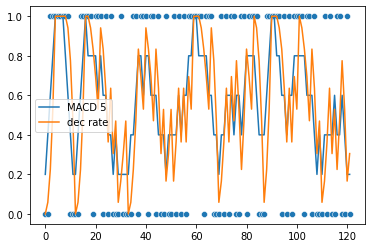

In [ ]:
import seaborn as sns
avai_dates_in_range_selected=[date for date in avai_dates_in_range if date>=dev_start_date.strftime('%Y-%m-%d') and date<dev_end_date.strftime('%Y-%m-%d')]
sns.scatterplot(x=np.arange(len(avai_dates_in_range_selected)),y=dev_data_dict["label"].values)

kernel_size=5
kernel = np.ones(kernel_size) / kernel_size
data_convolved = np.convolve(dev_data_dict["label"].values, kernel, mode='same')
sns.lineplot(x=np.arange(len(avai_dates_in_range_selected)),y=data_convolved, label="MACD 5")

kernel2 = (np.arange(kernel_size)**1.5)
kernel2=kernel2/np.sum(kernel2)
data_convolved = np.convolve(dev_data_dict["label"].values, kernel2, mode='same')
sns.lineplot(x=np.arange(len(avai_dates_in_range_selected)),y=data_convolved, label="dec rate")

Cleaning Tweets

In [ ]:
dev_data_dict_cleaned = DeepCleanse(dev_data_dict["tweets_window"], test_data_dict["tweets_window"])
dev_data_dict_cleaned.deepTextCleanse('body')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Cleaning News

In [ ]:
counter = 1
for i in range(0, 25):
  dev_data_dict_cleaned = DeepCleanse(dev_data_dict["news_window"], test_data_dict["news_window"])
  dev_data_dict_cleaned.deepTextCleanse('Top{}'.format(counter))
  counter = counter + 1

In [ ]:
import sys
print(sys.getsizeof(dev_data_dict["tweets_window"]))

print(test_data_dict["tweets_window"]["body"].values[0])

# ??? wierd


In [ ]:
# print(test_data_dict['tweets_window']['Label'].value_counts())
print(f"Dev set label counts: \n {dev_data_dict['news_window']['Label'].value_counts()} \n")
print(f"Test set label counts: \n {test_data_dict['news_window']['Label'].value_counts()}")

Split dev dataset into *Train* and *Validation*

In [ ]:

print(f"days of train set (including weekend): {(train_end_date-train_start_date).days}")
print(f"days of val set (including weekend): {(val_end_date-val_start_date).days}")
print(f"train_start_date: {train_start_date.date()}, val_start_date: {val_start_date.date()}")

train_set_list=split_dataset_into_window_chunck(train_start_date,train_end_date,dev_data_dict)
val_set_list=split_dataset_into_window_chunck(val_start_date,val_end_date,dev_data_dict)



days of train set (including weekend): 142
days of val set (including weekend): 35
train_start_date: 2015-01-01, val_start_date: 2015-05-23
Len of dataset 132
Len of dataset 25


In [ ]:
# print(test_data_dict['tweets_window']['Label'].value_counts())

print(f"Train set label counts: \n {train_set_list[0]['news_window']['Label'].value_counts()} \n")
print(f"Val set label counts: \n {val_set_list[0]['news_window']['Label'].value_counts()}")

In [ ]:
print(train_set_list[0]['label'])

0


# Dataset visualization

In [ ]:
#Helper function
def check_freq(x):
    freq = {}
    for c in set(x):
       freq[c] = x.count(c)
    return freq


In [ ]:
print(dev_data_dict["news_window"].columns)

In [ ]:
news_rows_data=dev_data_dict["news_window"][['Top1','Label']]
news_rows_data['Top1'] = dev_data_dict["news_window"]['Top1'].str.cat(dev_data_dict["news_window"][[ 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25']], sep=' ')
# news_together
news_rows_data_list=news_rows_data.values.tolist()
print(len(news_rows_data_list[0]))


In [ ]:
all_word_freq_by_company_dict={}
all_word_label1_freq_by_company_dict={}


all_word_freq_1ct_by_company_dict={}
all_word_label1_freq_1ct_by_company_dict={}

tweets_by_company=dev_data_dict["tweets_window"].groupby('ticker_symbol')[['body','Label']].apply(lambda g: g.values.tolist()).to_dict()

for company in tweets_by_company:
    one_company_tweets=tweets_by_company[company]
    # for i, (index, row) in enumerate(dev_data_dict["tweets_window"].iterrows()):
    all_word_freq_dict, all_word_label1_freq_dict, all_word_freq_1ct_dict, all_word_label1_freq_1ct_dict={}, {}, {}, {}
    for i, line in enumerate(one_company_tweets):
        label=int(line[1])
        freq_dict=nltk.FreqDist(line[0].split(' '))       
        for key in freq_dict:
            if key in ['appl','aapl','msft','goog','googl','amzn','tsla','stock','market','fb','apple']:
                continue
            if key not in all_word_freq_dict:
                all_word_freq_dict[key]=0
                all_word_label1_freq_dict[key]=0
                all_word_freq_1ct_dict[key]=0
                all_word_label1_freq_1ct_dict[key]=0
      
            all_word_freq_dict[key]+=freq_dict[key]
            all_word_label1_freq_dict[key]+=freq_dict[key]*label
            
            all_word_freq_1ct_dict[key]+=1 if freq_dict[key]>0 else 0
            all_word_label1_freq_1ct_dict[key]+=1 if (freq_dict[key]*label >0) else 0
        if i>200000:
            break

    all_word_freq_by_company_dict[company]=all_word_freq_dict
    all_word_label1_freq_by_company_dict[company]=all_word_label1_freq_dict
    all_word_freq_1ct_by_company_dict[company]=all_word_freq_1ct_dict
    all_word_label1_freq_1ct_by_company_dict[company]=all_word_label1_freq_1ct_dict
            
        # Turnc before cleaning ???
        


all_word_freq_dict, all_word_label1_freq_dict, all_word_freq_1ct_dict, all_word_label1_freq_1ct_dict={}, {}, {}, {}
for i, line in enumerate(news_rows_data_list):
        label=int(line[1])
        freq_dict=nltk.FreqDist(line[0].split(' '))        
        for key in freq_dict:
            if key not in all_word_freq_dict:
                all_word_freq_dict[key]=0
                all_word_label1_freq_dict[key]=0
                all_word_freq_1ct_dict[key]=0
                all_word_label1_freq_1ct_dict[key]=0
      
            all_word_freq_dict[key]+=freq_dict[key]
            all_word_label1_freq_dict[key]+=freq_dict[key]*label
            
            all_word_freq_1ct_dict[key]+=1 if freq_dict[key]>0 else 0
            all_word_label1_freq_1ct_dict[key]+=1 if (freq_dict[key]*label >0) else 0

#         all_word_freq_by_company_dict[company]=all_word_freq_dict
#         all_word_label1_freq_by_company_dict[company]=all_word_label1_freq_dict
#         all_word_freq_1ct_by_company_dict[company]=all_word_freq_1ct_dict
#         all_word_label1_freq_1ct_by_company_dict[company]=all_word_label1_freq_1ct_dict

all_word_freq_by_company_dict["news"]=all_word_freq_dict
all_word_label1_freq_by_company_dict["news"]=all_word_label1_freq_dict
all_word_freq_1ct_by_company_dict["news"]=all_word_freq_1ct_dict
all_word_label1_freq_1ct_by_company_dict["news"]=all_word_label1_freq_1ct_dict
          

# for key in all_word_freq_dict:
#     print(f"{key}: {all_word_freq_dict[key]}")

# for key in all_word_label1_freq_dict:
#     print(f"{key}: {all_word_freq_dict[key]}")

# for key in all_word_freq_1ct_by_company_dict['AAPL']:
#     print(f"{key}: {all_word_freq_1ct_by_company_dict['AAPL'][key]}")

print(all_word_label1_freq_1ct_by_company_dict["news"])

# TF-IDF (An attempt)



In [ ]:
#train_set_list
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

tweets_window_vector_list = []
news_window_vector_list=[]
prices_window_vector_list=[]

train_set_list[1]['tweets_window']

for i in range(0, len(train_set_list)):
  tweets_window_vector = vectorizer.fit_transform(train_set_list[i]['tweets_window'].body)
  tweets_window_vector_list.append(tweets_window_vector)

  news_vector=[]
  for j in range(1, 24):

    news_window_vector = vectorizer.fit_transform(train_set_list[i]['news_window'][f'Top{j}'])
    news_vector.append(news_window_vector)

  news_window_vector_list.append(news_vector)
  prices_window_vector_list.append(train_set_list[i]["prices"])


  
# input
# train_set_list[1]['label']
# window_length
# for i in range(n):
#   train_set_list[i] -> dict({"feature":"vec", "lable":"label"})

#   train_set_list[i]={"tweets_window":tweets_window,"news_window":news_window,"prices":prices,"label":label}
#   for j in rang(window_length):
#       train_set_list[i]["tweets_window"][j] -> tf_idf_model()-> vec
#       train_set_list[i]["news_window"][j] -> tf_idf_model()-> vec
#       stack("tweets_window"+"news_window"+"prices")  into vec

# # output
# train_dataset=dict({"feature":"vec", "lable":"label"})

In [ ]:
def vec_chunk_set_for_tf_idf(vec_data_set_lists, data_set_list):
    vec_ds=[]
    for sample in data_set_list:
        _n, _tweet_vec, _news_vec, _prices_vec=trans_day_to_vec(sample) 
        d2v_train_feat=[]
        for i in range(_n):
          # print(len(tweet_vec[i]))
          _tweet_vec_emb=sen_models["tweets_model"].infer_vector(_tweet_vec[i].split())
          _news_vec_emb=sen_models["news_model"].infer_vector(_news_vec[i].split())
          _prices_vec_emb=np.array(_prices_vec[i]).reshape(-1)
          # print(_tweet_vec_emb.shape)
          # print(_news_vec_emb.shape)
          # print(_prices_vec_emb.shape)

          stack_vec=np.hstack([_tweet_vec_emb,_news_vec_emb,_prices_vec_emb])
          d2v_train_feat.append(stack_vec)
          # print(stack_vec.shape)
        vec_ds.append({"feat":np.array(d2v_train_feat), "label":sample["label"].values[-1]})
    return vec_ds

In [ ]:
# train_vec_data_set_lists=
# tfidf_train_ds=vec_chunk_set_for_tf_idf(vec_data_set_lists)

In [ ]:
print(train_set_list[0]['label'])

# Sentence to vector

In [ ]:
# print(train_set_list[0])
print(len(train_set_list))
print(train_set_list[10]["tweets_window"]["tweet_id"])
# print(val_set_list)


ds=[]
for i in range(100):
  ip=np.random.rand(30,500)
  lb=random.random()*2//2
  ds.append(dict({"feat":ip,"label":lb}))

train_ds=ds.copy()
val_ds=ds.copy()

print(train_ds)

In [ ]:
# % pip install --ignore-installed sent2vec 

Doc 2 vec for news

In [ ]:
import os
import gensim
from gensim.models import Doc2Vec

TaggedDocument= gensim.models.doc2vec.TaggedDocument
def doc2vec_model(docs, train_docs, output_dim=100):
    def X_train_d2v(docs):
      x_train=[]
      for d_id, d in enumerate(docs):
        for i, s in enumerate(d):
          wl=s.split(" ")
          document=TaggedDocument(wl,tags=[d_id,i])
          x_train.append(document)
      return x_train

    def train(X_docs, X_train):
      model = gensim.models.Doc2Vec(vector_size=output_dim, window=3, min_count=5, alpha=0.025, min_alpha=0.025)
      model.build_vocab(X_docs)
      model.train(X_train,total_examples=model.corpus_count, epochs=10)
      return model
    X_docs=X_train_d2v(docs)
    X_train=X_train_d2v(train_docs)
    model=train(X_docs, X_train)
    return model


In [ ]:
x_data=dev_data_dict["news_window"].loc[:, ~dev_data_dict["news_window"].columns.isin(['Date', 'Datetime', 'Label'])]
docs=np.array(x_data)
print(docs.shape)

news_model=doc2vec_model(docs,docs, output_dim=news_vec_len)


In [ ]:
tweets_data_set_dev=np.array(dev_data_dict["tweets_window"]["body"])

sample_size=(dev_end_date-dev_start_date).days*each_day_tweets_used_train
random_indices = np.random.choice(tweets_data_set_dev.shape[0], 
                      size=sample_size, replace=False)
tweets_data_set_train = tweets_data_set_dev[random_indices]
print(tweets_data_set_train)
tweets_model=doc2vec_model(tweets_data_set_dev,tweets_data_set_train,output_dim=tweets_vec_len) 
#Train the vocabulary list by the whole tweets, but train the data with only randome selected sample.

In [ ]:
print(dev_end_date-dev_start_date)
print(tweets_data_set_dev.shape[0])

In [ ]:
def trans_day_to_vec(sample):
  _tweets_dic=sample["tweets_window"].groupby('Date')['body'].apply(list).to_dict()
  _news_dic=sample["news_window"].groupby('Date')['Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 
                                                   'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 
                                                   'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25'].apply(list).to_dict()


  num_days=len(_tweets_dic.keys())
  tweet_vec=[]
  news_vec=[]
  _prices_vec=[]  
  for key in sorted(_tweets_dic.keys()):
    _tweet=_tweets_dic[key]

    random_indices = np.random.choice(len(_tweet), 
                      size=each_day_tweets_used_train//num_days, replace=False)
    _tweet_sample_train = np.array(_tweet)[random_indices]
    tweet_vec.append(" ".join(_tweet_sample_train))

    _news=sample["news_window"].loc[sample["news_window"]["Date"]==key]
    _news_sample_train=np.array(_news.drop(['Date', "Datetime","Label"], axis=1)).reshape(-1)
    news_vec.append(" ".join(_news_sample_train))

    _prices=sample["prices"].loc[sample["prices"]["Date"]==key]
    _prices_vec.append(np.array(_prices.drop(['Date', "Datetime"], axis=1)).reshape(-1))
  return num_days, tweet_vec, news_vec, _prices_vec


In [ ]:
def vec_chunk_set(data_set_list, sen_models):
    vec_ds=[]
    for sample in data_set_list:
        _n, _tweet_vec, _news_vec, _prices_vec=trans_day_to_vec(sample) 
        d2v_train_feat=[]
        for i in range(_n):
          # print(len(tweet_vec[i]))
          _tweet_vec_emb=sen_models["tweets_model"].infer_vector(_tweet_vec[i].split())
          _news_vec_emb=sen_models["news_model"].infer_vector(_news_vec[i].split())
          _prices_vec_emb=np.array(_prices_vec[i]).reshape(-1)
          # print(_tweet_vec_emb.shape)
          # print(_news_vec_emb.shape)
          # print(_prices_vec_emb.shape)

          stack_vec=np.hstack([_tweet_vec_emb,_news_vec_emb,_prices_vec_emb])
          d2v_train_feat.append(stack_vec)
          # print(stack_vec.shape)
        vec_ds.append({"feat":np.array(d2v_train_feat), "label":sample["label"]})
    return vec_ds

In [ ]:
val_set_list[1]

In [ ]:
sen_models={"tweets_model":tweets_model, "news_model":news_model}
d2v_train_ds=vec_chunk_set(train_set_list,sen_models)
d2v_val_ds=vec_chunk_set(val_set_list,sen_models)

test_set_list=split_dataset_into_window_chunck(test_start_date,test_end_date,test_data_dict)
d2v_test_ds=vec_chunk_set(test_set_list,sen_models)



# print(np.array(d2v_train_ds).shape)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Len of dataset 34


In [ ]:
d2v_train_ds[0]['label']

0

In [ ]:
print(d2v_train_ds[0])
print(len(d2v_train_ds))
print(len(d2v_val_ds))
print(d2v_test_ds[0])
print(len(d2v_test_ds))

print(d2v_train_ds[0]["feat"].shape)
print(d2v_train_ds[2]["feat"].shape)

In [ ]:
print(len(encoded_imgs[0]))

Andre's Part



In [ ]:
%who DataFrame

# LR/RF

In [ ]:
min_day=min([d2v_train_ds[i]["feat"].shape[0] for i in range(len(d2v_train_ds))]) # minimum number of days each window has

In [ ]:
# training, validation, test set for Random Forest
X_train = np.array([])
y_train = np.array([])
window_shape=d2v_train_ds[0]["feat"].shape
for i in range(len(d2v_train_ds)):
  single = d2v_train_ds[i]["feat"][:min_day,:].reshape(1, min_day*window_shape[1])
  X_train = np.append(X_train, single)
  y_train = np.append(y_train,d2v_train_ds[i]["label"])
X_train = X_train.reshape(len(d2v_train_ds),min_day*window_shape[1])

X_val = np.array([])
y_val = np.array([])
window_shape=d2v_val_ds[0]["feat"].shape
for i in range(len(d2v_val_ds)):
  single = d2v_val_ds[i]["feat"][:min_day,:].reshape(1, min_day*window_shape[1])
  X_val = np.append(X_val, single)
  y_val = np.append(y_val,d2v_val_ds[i]["label"])
X_val = X_val.reshape(len(d2v_val_ds),window_shape[0]*window_shape[1])

X_test = np.array([])
y_test = np.array([])
window_shape=d2v_test_ds[0]["feat"].shape
for i in range(len(d2v_test_ds)):
  single = d2v_test_ds[i]["feat"][:min_day,:].reshape(1, min_day*window_shape[1])
  X_test = np.append(X_test, single)
  y_test = np.append(y_test,d2v_test_ds[i]["label"])
X_test = X_test.reshape(len(d2v_test_ds),window_shape[0]*window_shape[1])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# estimator tuning
n_estimators = np.arange(400, 700, 100)
min_sample_split = np.linspace(0.002, 0.2,3)

grid_rf = GridSearchCV(RandomForestClassifier(random_state=0),
                       param_grid = {
                           "n_estimators":n_estimators,
                           "min_samples_split": min_sample_split,
                           "oob_score":[True],
                           "warm_start":[True]},
                       return_train_score=True)
grid_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'min_samples_split': array([0.002, 0.101, 0.2  ]),
                         'n_estimators': array([400, 500, 600]),
                         'oob_score': [True], 'warm_start': [True]},
             return_train_score=True)

In [ ]:
print(f"Best score:", grid_rf.best_score_)
print(f"Best alpha:", grid_rf.best_params_)
print(f"Test score:", grid_rf.score(X_test, y_test))

Best score: 0.5906432748538011
Best alpha: {'min_samples_split': 0.002, 'n_estimators': 400, 'oob_score': True, 'warm_start': True}
Test score: 0.375


In [ ]:
from pyts.classification import TimeSeriesForest

# time series forest
n_estimators = np.arange(500, 801, 100)
min_samples_leaf = np.linspace(0.002, 0.3,3)
n_windows=np.arange(1,6,2)

grid_tsf = GridSearchCV(TimeSeriesForest(random_state=0),
                       param_grid = {
                           "n_estimators":n_estimators,
                           "min_samples_leaf": min_samples_leaf,
                           "n_windows": n_windows,
                           "oob_score":[True]},
                       return_train_score=True)
grid_tsf.fit(X_train, y_train)

GridSearchCV(estimator=TimeSeriesForest(random_state=0),
             param_grid={'min_samples_leaf': array([0.002, 0.151, 0.3  ]),
                         'n_estimators': array([500, 600, 700, 800]),
                         'n_windows': array([1, 3, 5]), 'oob_score': [True]},
             return_train_score=True)

In [ ]:
print(f"Best score:", grid_tsf.best_score_)
print(f"Best alpha:", grid_tsf.best_params_)
print(f"Test score:", grid_tsf.score(X_test, y_test))

Best score: 0.6269005847953217
Best alpha: {'min_samples_leaf': 0.002, 'n_estimators': 500, 'n_windows': 3, 'oob_score': True}
Test score: 0.625


# LSTM

Normalization

In [ ]:
def dev(dataset):
  d2v = []
  i = 0
  for d in dataset:
    for k in d['feat']:
      d2v.append(k)
  return np.mean(d2v,axis=0), np.std(d2v,axis=0)

In [ ]:
def norm(dataset,mean,var):
  norm_d2v = []
  i = 0
  for d in dataset:
    if d['feat'].shape[0]==4:
      norm_d2v.append({})
      norm_d2v[i]['feat'] = np.append(np.array([[0]*len(d['feat'][0])]),[(np.array(d['feat']) - mean)/var])
      norm_d2v[i]['feat'] = np.reshape(norm_d2v[i]['feat'],(5,256))
    else:
      norm_d2v.append({})
      norm_d2v[i]['feat'] = (np.array(d['feat']) - mean)/var
    norm_d2v[i]['label'] = d['label']
    i += 1
  return norm_d2v

In [ ]:
m,v = dev(d2v_train_ds+d2v_val_ds)
norm_d2v_train = norm(d2v_train_ds, m, v)
norm_d2v_val = norm(d2v_val_ds, m, v)
norm_d2v_test = norm(d2v_test_ds, m, v)


In [ ]:
def reform(dataset,start,end):
  reshape_d2v = []
  i = 0
  for d in dataset:
    reshape_d2v.append({})
    reshape_d2v[i]['feat'] = d['feat'][:,start:end]
    reshape_d2v[i]['label'] = d['label']
    i += 1
  return reshape_d2v

Model

In [ ]:
from torch.functional import Tensor
# -*- coding: UTF-8 -*-
class Net(Module):
    '''
    pytorch prediction model
    '''
    def __init__(self, config):
        super(Net, self).__init__()

        self.lstm = LSTM(input_size=config.input_size, hidden_size=config.hidden_size,
                         num_layers=config.lstm_layers, batch_first=True, dropout=config.dropout_rate, bidirectional=True)
        self.linear = Linear(in_features=config.hidden_size*2, out_features=config.output_size)

    def forward(self, x, hidden=None):
        lstm_out, hidden = self.lstm(x, hidden)
        linear_out = self.linear(lstm_out)
        out = torch.sigmoid(linear_out)
        return out, hidden


def train(config, logger, data):
    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu") # CPU or GPU
    train,val = data
    model = Net(config).to(device)      
    if config.add_train:                
        model.load_state_dict(torch.load(config.model_save_path + config.model_name))
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = torch.nn.BCELoss()      

    valid_loss_min = float("inf")
    bad_epoch = 0
    global_step = 0
    for epoch in range(config.epoch):
        logger.info("Epoch {}/{}".format(epoch, config.epoch))
        model.train()                   
        train_loss_array = []
        hidden_train = None
        for i, _data in enumerate(train):
            # _train_X = torch.Tensor([[np.reshape(_data['feat'],(-1))]])
            _train_X = torch.Tensor([[_data['feat'][-1,:]]])
            _train_Y = torch.Tensor([[[_data['label']]]])
            optimizer.zero_grad()               
            pred_Y, hidden_train = model(_train_X, hidden_train)    

            if not config.do_continue_train:
                hidden_train = None             
            else:                               # continue training
                h_0, c_0 = hidden_train
                h_0.detach_(), c_0.detach_()    
                hidden_train = (h_0, c_0)
            loss = criterion(pred_Y, _train_Y)  # compute loss
            loss.backward()                     
            optimizer.step()                    # update parameter
            train_loss_array.append(loss.item())
            global_step += 1

        
        model.eval()                    
        valid_loss_array = []
        hidden_valid = None
        for _data in val:
            # _valid_X = torch.Tensor([[np.reshape(_data['feat'],(-1))]])
            _valid_X = torch.Tensor([[_data['feat'][-1,:]]])
            _valid_Y = torch.Tensor([[[_data['label']]]])
            pred_Y, hidden_valid = model(_valid_X, hidden_valid)
            if not config.do_continue_train: hidden_valid = None
            loss = criterion(pred_Y, _valid_Y)  
            valid_loss_array.append(loss.item())

        train_loss_cur = np.mean(train_loss_array)
        valid_loss_cur = np.mean(valid_loss_array)
        logger.info("The train loss is {:.6f}. ".format(train_loss_cur) +
              "The valid loss is {:.6f}.".format(valid_loss_cur))

        if valid_loss_cur < valid_loss_min:
            valid_loss_min = valid_loss_cur
            bad_epoch = 0
            torch.save(model.state_dict(), config.model_save_path + config.model_name)  # save model
        else:
            bad_epoch += 1
            if bad_epoch >= config.patience:    
                logger.info(" The training stops early in epoch {}".format(epoch))
                break


def predict(config,test):

    # model
    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu")
    model = Net(config).to(device)
    model.load_state_dict(torch.load(config.model_save_path + config.model_name))   

    # store the predict result
    result = torch.Tensor().to(device)

    # prediction
    model.eval()
    hidden_predict = None
    for _data in test:
        # data_X = torch.Tensor([[np.reshape(_data['feat'],(-1))]])
        data_X = torch.Tensor([[_data['feat'][-1,:]]])
        pred_X, hidden_predict = model(data_X, hidden_predict)
        cur_pred = torch.squeeze(pred_X, dim=0)
        result = torch.cat((result, cur_pred), dim=0)

    return result.detach().cpu().numpy()    


Train

In [ ]:
# 150,100,6

In [ ]:
# -*- coding: UTF-8 -*-
class Config:
    # data
    predict_day = 1             

    # lstm
    # input_size = norm_d2v_train[0]['feat'].shape[0]*norm_d2v_train[0]['feat'].shape[1]
    input_size = norm_d2v_train[0]['feat'].shape[1]
    output_size = 1

    hidden_size = 128           
    lstm_layers = 4             # layer numbers
    dropout_rate = 0.2          # dropout probability

    # train
    do_train = True
    do_predict = True
    add_train = False           
    shuffle_train_data = False   
    use_cuda = False                 

    batch_size = 10
    learning_rate = 0.001
    epoch = 20                  
    patience = 5                # stop training if no increase for val in patience epochs
    random_seed = 42            

    do_continue_train = True    # batch_size = 1, use previous final_state as init_state
    continue_flag = ""           
    if do_continue_train:
        shuffle_train_data = False
        batch_size = 1
        continue_flag = "continue_"

    # frame
    used_frame = 'pytorch'  
    model_postfix = ".pth"
    model_name = "model_" + continue_flag + used_frame + model_postfix

    # path
    model_save_path = "./checkpoint/" 
    figure_save_path = "./figure/"
    log_save_path = "./log/"
    do_log_print_to_screen = False
    do_log_save_to_file = True                          
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)    
    if not os.path.exists(figure_save_path):
        os.mkdir(figure_save_path)
    if do_train and (do_log_save_to_file):
        cur_time = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
        log_save_path = log_save_path + cur_time + '_' + used_frame + "/"
        os.makedirs(log_save_path)

def load_logger(config):
    logger = logging.getLogger()
    logger.setLevel(level=logging.DEBUG)

    # StreamHandler
    if config.do_log_print_to_screen:
        stream_handler = logging.StreamHandler(sys.stdout)
        stream_handler.setLevel(level=logging.INFO)
        formatter = logging.Formatter(datefmt='%Y/%m/%d %H:%M:%S',
                                      fmt='[ %(asctime)s ] %(message)s')
        stream_handler.setFormatter(formatter)
        logger.addHandler(stream_handler)

    # FileHandler
    if config.do_log_save_to_file:
        file_handler = RotatingFileHandler(config.log_save_path + "out.log", maxBytes=1024000, backupCount=5)
        file_handler.setLevel(level=logging.INFO)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

        # save config to log file
        config_dict = {}
        for key in dir(config):
            if not key.startswith("_"):
                config_dict[key] = getattr(config, key)
        config_str = str(config_dict)
        config_list = config_str[1:-1].split(", '")
        config_save_str = "\nConfig:\n" + "\n'".join(config_list)
        logger.info(config_save_str)

    return logger

def main(config,dev_data, test_data):
    logger = load_logger(config)
    try:
        np.random.seed(config.random_seed)  

        if config.do_train:
            train(config, logger, dev_data)

        if config.do_predict:
            pred_result = predict(config, test_data) 
            print(pred_result)
            return pred_result      
    except Exception:
        logger.error("Run Error", exc_info=True)
     
def pre_loss(dataset,pre):
    i = 0
    loss = 0
    for d in dataset:
      if pre[i][0]>0.5:
        loss+=(1-d['label'])
      else:        
        loss+=(d['label'])
      i += 1
    return 1-loss/len(pre)

if __name__=="__main__":
    con = Config()
    dev = (norm_d2v_train, norm_d2v_val)
    test = norm_d2v_test
    pred_result = main(con, dev, test);
    print(pre_loss(norm_d2v_test,pred_result))
    
    dev_news = (reform(norm_d2v_train,0,150), reform(norm_d2v_val,0,150))
    test_news = reform(norm_d2v_test,0,150)
    con.input_size = test_news[0]['feat'].shape[1]
    pred_result_news = main(con, dev_news, test_news);
    print(f"news: {pre_loss(norm_d2v_test,pred_result)}")

    dev_tweets = (reform(norm_d2v_train,150,250), reform(norm_d2v_val,150,250))
    test_tweets = reform(norm_d2v_test,150,250)
    con.input_size = test_tweets[0]['feat'].shape[1]
    pred_result_tweets = main(con, dev_tweets, test_tweets);
    print(f"tweets: {pre_loss(norm_d2v_test,pred_result_tweets)}")

    dev_price = (reform(norm_d2v_train,250,256), reform(norm_d2v_val,250,256))
    test_price = reform(norm_d2v_test,250,256)
    con.input_size = test_price[0]['feat'].shape[1]
    pred_result_price = main(con, dev_price, test_price);
    print(f"prices: {pre_loss(norm_d2v_test,pred_result_price)}")

[ 2021/12/16 03:27:23 ] 
Config:
'add_train': False
'batch_size': 10
'continue_flag': ''
'cur_time': '2021_12_16_03_27_23'
'do_continue_train': False
'do_log_print_to_screen': True
'do_log_save_to_file': True
'do_predict': True
'do_train': True
'dropout_rate': 0.2
'epoch': 20
'figure_save_path': './figure/'
'hidden_size': 128
'input_size': 1280
'learning_rate': 0.001
'log_save_path': './log/2021_12_16_03_27_23_pytorch/'
'lstm_layers': 4
'model_name': 'model_pytorch.pth'
'model_postfix': '.pth'
'model_save_path': './checkpoint/'
'output_size': 1
'patience': 5
'predict_day': 1
'random_seed': 42
'shuffle_train_data': True
'use_cuda': False
'used_frame': 'pytorch'
[ 2021/12/16 03:27:23 ] 
Config:
'add_train': False
'batch_size': 10
'continue_flag': ''
'cur_time': '2021_12_16_03_27_23'
'do_continue_train': False
'do_log_print_to_screen': True
'do_log_save_to_file': True
'do_predict': True
'do_train': True
'dropout_rate': 0.2
'epoch': 20
'figure_save_path': './figure/'
'hidden_size': 128
'in

TypeError: ignored

In [ ]:
test_label = []
for d in d2v_test_ds:
  test_label.append(d['label'])
sum(np.array(test_label)==1)/len(test_label)

In [ ]:
i = 0
loss = 0
for d in d2v_test_ds:
  if pred_result[i][0]>0.5:
    loss+=(1-d['label'])
  else:
    
    loss+=(d['label'])
  # print(d['label'])
  i += 1
print(1-loss/len(pred_result))

In [ ]:
pred_result[1][0]>0.6

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
con = Config()
device = torch.device("cpu") 
valid_X = []
for _data in norm_d2v_train[:20]:
    valid_X.append(_data['feat'][-1,:])
valid_X = torch.Tensor([[valid_X[0]]]).to(device)

In [ ]:
test_loader = torch.utils.data.DataLoader(valid_X, batch_size=5, shuffle=True)
batch = next(iter(test_loader))
valid_X_batch = batch

In [ ]:
model = Net(con).to(device)
# model.load_state_dict(torch.load(con.model_save_path + con.model_name))

explainer = shap.DeepExplainer(model,valid_X)